In [248]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pandas as pd
import requests
import io

class DataGenerator(torch.utils.data.Dataset):
    """
    Data generator for the m6A model. It randomly selects
    batches from the data to train the m6A model.
    """
    def __init__(self, features, labels, random_state=None):
        """
        Constructor for the data generator class, expects features
        and labels matrices.
        :param features: numpy.array, Nx15, N=number of sequences,
                                      each sequence is of length 15.
        :param labels: numpy array, one hot encoded labels for whether
                                    a sequence in features variable contains
                                    methylated A or not.
        :param random_state: numpy.random_state, allow reproducibility by selecting
                                                 a seed for random operations beforehand.
        """
        self.random_state = random_state
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        """
        Get random indices from the training data
        to form batches.
        :param idx: numpy.array, indices to retrieve, ignoring for now.
        :return: x, y: features and labels from selected indices.
        """
        i = self.random_state.choice(len(self.features))

        x = self.features[i]
        y = self.labels[i]

        x = torch.tensor(x)
        y = torch.tensor(y)

        return x, y


def m6AGenerator(data_path, random_state=None, pin_memory=True,
                 num_workers=0, batch_size=32):
    """
    This generator returns a training data generator as well as
    validation features and labels
    :param data_path: str, path where the data matrix is stored.
    :param random_state: int, seed for numpy random_state.
    :param pin_memory: bool, Makes CUDA efficient by skipping one copy
                             operation, true by default.
    :param num_workers: int, number of worker threads the generator can
                             utilize, 0 by default.
    :param batch_size: int, number of examples in each batch
    :return: X_gen: training data generator, X_val: validation features, y_val: validation labels
    """
    # initialize Random state
    random_state = np.random.RandomState(random_state)

    # Load training and validation data
    train_val_data = np.load(data_path, allow_pickle=True)

    # Get the dictionary from the containing relevant data
    train_val_data = train_val_data['save_data_dict'][()]

    # Load training and validation features and labels
    X_train = train_val_data['X_train']
    y_train = train_val_data['y_train']
    X_val = train_val_data['X_val']
    y_val = train_val_data['y_val']

    print(f"Training features shape {X_train.shape}, training labels shape: {y_train.shape}")
    print(f"Validation features shape {X_val.shape}, validation labels shape: {y_val.shape}")

    # Get the training data generator
    X_gen = DataGenerator(X_train,
                          y_train,
                          random_state=random_state)

    # Wrap it in a data loader
    X_gen = torch.utils.data.DataLoader(X_gen,
                                        pin_memory=pin_memory,
                                        num_workers=num_workers,
                                        batch_size=batch_size)

    return X_gen, (X_val, y_val)

In [249]:
X_train, (X_val, y_val) = m6AGenerator("./m6A_train_more.npz", random_state=None, pin_memory=True, num_workers=2, batch_size=32)

Training features shape (180503, 7, 15), training labels shape: (180503, 2)
Validation features shape (60168, 7, 15), validation labels shape: (60168, 2)


In [252]:
X_val.shape

(60168, 7, 15)

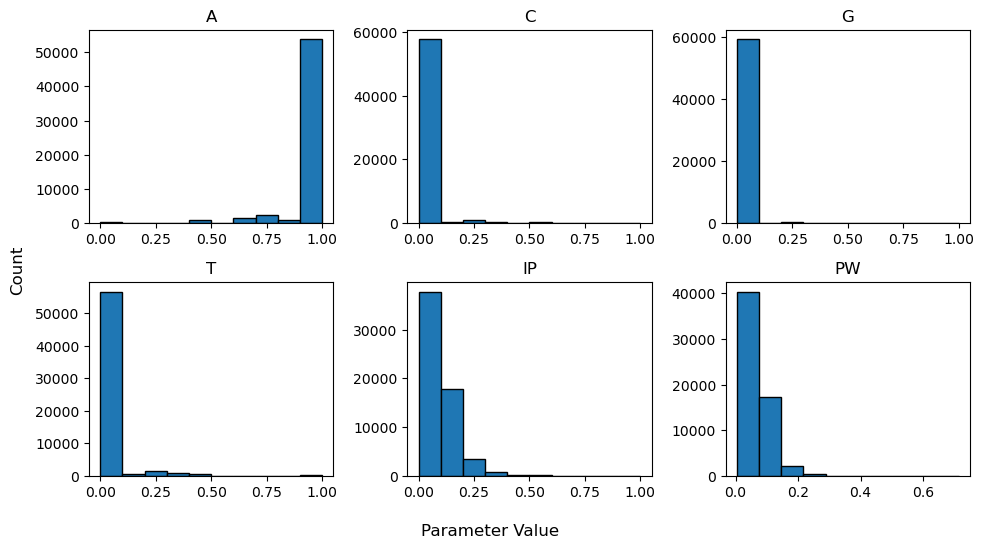

In [120]:
parameters = ['A', 'C', 'G', 'T', 'IP', 'PW']
fig, axs = plt.subplots(2, 3, figsize=(10, 5.5))
for i in range(6):
    axs.flat[i].hist(X_val[:, i, 7], edgecolor="black")
    axs.flat[i].set_title(f"{parameters[i]}")
fig.supylabel("Count")
fig.supxlabel("Parameter Value")
fig.tight_layout()

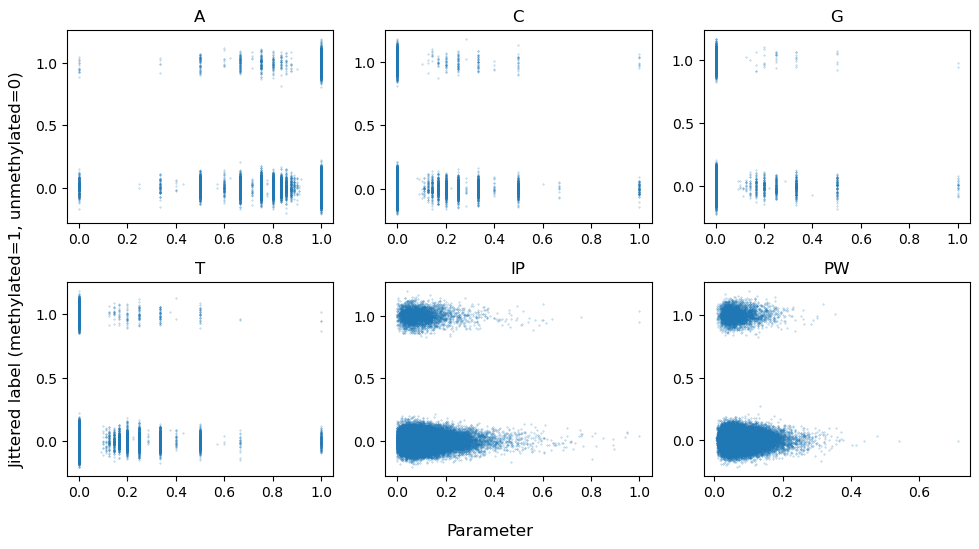

In [121]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5.5))
for i in range(6):
    axs.flat[i].scatter(X_val[:, i, 7], y_val[:, 0] + np.random.normal(loc=0, scale=.05, size=y_val[:, 0].shape), s=.1, alpha=.5)
    axs.flat[i].set_title(f"{parameters[i]}")
fig.supxlabel("Parameter")
fig.supylabel("Jittered label (methylated=1, unmethylated=0)") 
fig.tight_layout()

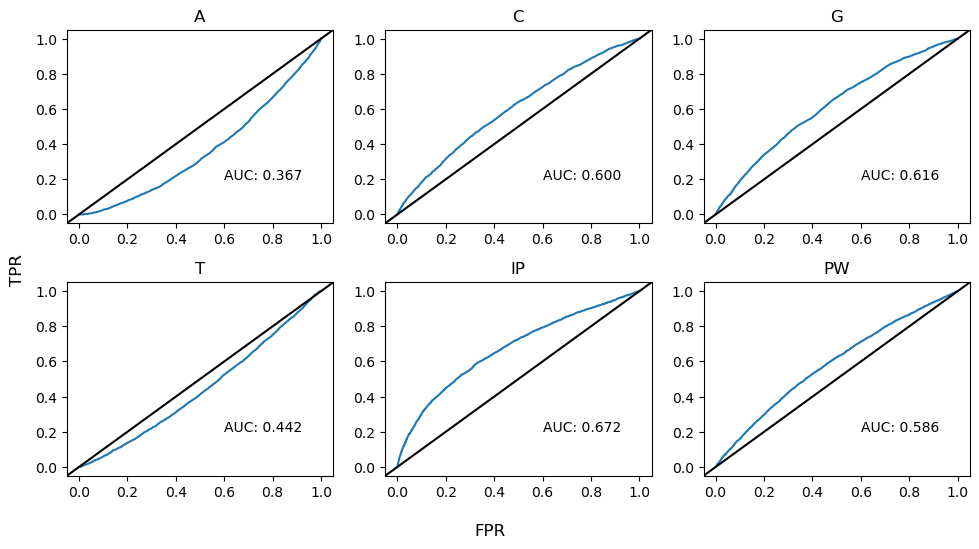

In [122]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5.5))
for i in range(6):
    fpr, tpr, thresholds = metrics.roc_curve(y_val[:, 0], np.sum(X_val[:, i, :], axis=1), pos_label=1)
    axs.flat[i].plot(fpr, tpr)
    axs.flat[i].axline([0,0], slope=1, c="black")
    axs.flat[i].text(.6, .2, f"AUC: {metrics.auc(fpr, tpr):.03f}") 
    axs.flat[i].set_title(f"{parameters[i]}")
fig.supxlabel("FPR")
fig.supylabel("TPR")
fig.tight_layout()

In [123]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [124]:
X_val.shape[1] , X_val.shape[2], X_val.shape[1] * X_val.shape[2], X_val.shape[0]

(7, 15, 105, 60168)

In [132]:
losses = []
losses_test = []
Iterations = []
epochs = 50
training_loss = []
learning_rate = 0.0001

model = LogisticRegression(105, 1)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
X_val_flat = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    iteration = 0
    for batch in X_train:
        x = batch[0]
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2]).float()
        labels = batch[1][:,0].float()
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(x)
        loss = criterion(torch.squeeze(outputs), labels) 
        loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
        optimizer.step() # Updates weights and biases with the optimizer (SGD)
        training_loss.append(loss.detach().numpy())
        iteration += 1
        if iteration % 10000 == 0 : print(iteration)
    y_pred = model(torch.tensor(X_val_flat).float()).detach().numpy()
    y_obs = y_val[:, 0]
    fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
    print(f"AUC: {metrics.auc(fpr, tpr)}")


Epoch: 0
AUC: 0.6861053485118023
Epoch: 1
AUC: 0.7552537762760758
Epoch: 2
AUC: 0.7689173059157193
Epoch: 3
AUC: 0.7758497663745091
Epoch: 4
AUC: 0.7806082672623096
Epoch: 5
AUC: 0.7842488403594685
Epoch: 6
AUC: 0.7871836160314509
Epoch: 7
AUC: 0.7896005332948541
Epoch: 8
AUC: 0.7916307736466708
Epoch: 9
AUC: 0.7933624986618463
Epoch: 10
AUC: 0.794851958595598
Epoch: 11
AUC: 0.7961385322847346
Epoch: 12
AUC: 0.7972676515959132
Epoch: 13
AUC: 0.7982600972976016
Epoch: 14
AUC: 0.7991226199081802
Epoch: 15
AUC: 0.7998935349602616
Epoch: 16
AUC: 0.8005808952759892
Epoch: 17
AUC: 0.8011991676454757
Epoch: 18
AUC: 0.8017487398333243
Epoch: 19
AUC: 0.8022456467594595
Epoch: 20
AUC: 0.8026931880811677
Epoch: 21
AUC: 0.8030913613596776
Epoch: 22
AUC: 0.8034587890510417
Epoch: 23
AUC: 0.8037904765520646
Epoch: 24
AUC: 0.8040905161206379
Epoch: 25
AUC: 0.8043656436425148
Epoch: 26
AUC: 0.8046197806616107
Epoch: 27
AUC: 0.8048505103557732
Epoch: 28
AUC: 0.8050666318110998
Epoch: 29
AUC: 0.80526540

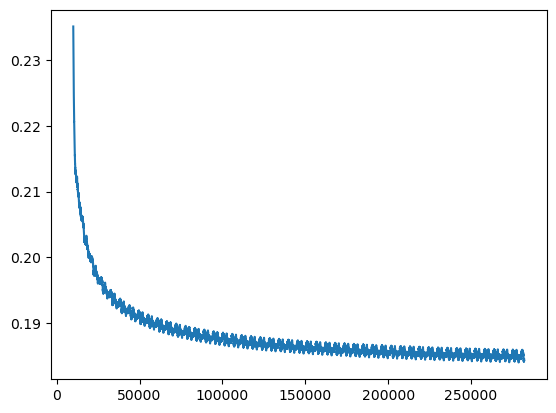

In [133]:
plt.plot(pd.Series(training_loss).rolling(10000).mean())

Text(0.6, 0.2, 'AUC: 0.807')

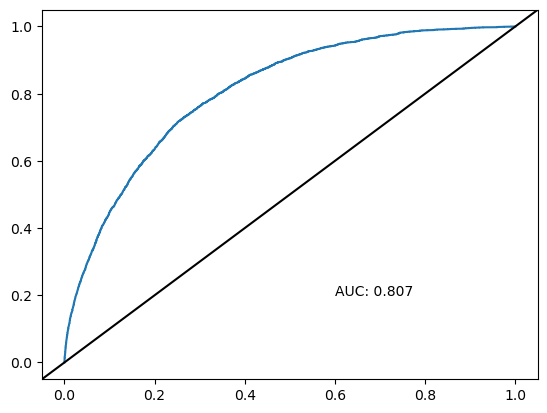

In [134]:
y_pred = model(torch.tensor(X_val_flat).float()).detach().numpy()
y_obs = y_val[:, 0]
fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
plt.plot(fpr, tpr)
plt.axline([0,0], slope=1, c="black")
plt.text(.6, .2, f"AUC: {metrics.auc(fpr, tpr):.03f}") 

In [135]:
confusion_raw = metrics.confusion_matrix(y_obs, y_pred>0.05) 
confusion_percent = np.transpose(confusion_raw.transpose()/confusion_raw.sum(axis=1)*100)
confusion_raw, confusion_percent, np.array([["TN", "FP"], ["FN", "TP"]] )

(array([[37864, 18678],
        [  772,  2854]]),
 array([[66.96614906, 33.03385094],
        [21.29067843, 78.70932157]]),
 array([['TN', 'FP'],
        ['FN', 'TP']], dtype='<U2'))

In [165]:
cnn_pred = np.load("ipd_match_cnn_results.npz", allow_pickle=True)["cnn_pred"][()]

y_all = cnn_pred['y']
pred_all = cnn_pred['pred']
ccs_all = cnn_pred['ccs']
subreads_all = cnn_pred['subreads']
m6a_calls_pos_all = cnn_pred['m6a_call_pos']

fpr, tpr, thresholds = metrics.roc_curve(y_all[:, 0], pred_all[:, 0], pos_label=1)
print(f"AUC-ROC: {metrics.auc(fpr, tpr):.03f}")

AUC-ROC: 0.881


In [185]:
y_all.shape,pred_all.shape, ccs_all.shape, subreads_all.shape, m6a_calls_pos_all.shape
ipd_df = pd.read_csv("https://phweb01.s.uw.edu/public/mvollger/ipdSummary.calls.tsv.gz", sep="\t")
ipd_df["ipdSummary"]=1
ipd_df["pos"] = ipd_df["pos"]-1

In [227]:
ipd_csv[ipd_csv.score>30].shape

(79644, 6)

In [261]:
cnn_pred = np.load("ipd_match_cnn_results.npz", allow_pickle=True)["cnn_pred"][()]

y_all = cnn_pred['y']
pred_all = cnn_pred['pred']
ccs_all = cnn_pred['ccs']
subreads_all = cnn_pred['subreads']
m6a_calls_pos_all = cnn_pred['m6a_call_pos']

ipd_csv = pd.read_csv("https://phweb01.s.uw.edu/public/mvollger/ipdSummary.calls.csv.gz")
ipd_csv["ipdSummary"]=1
ipd_csv["pos"] = ipd_csv["pos"]-1

df = pd.DataFrame(cnn_pred["pred"])
df["truth"] = y_all[:,0]
df["pred"] = pred_all[:,0]
df["fiber"] = ccs_all
df["subreads_all"]=subreads_all
df["pos"] = m6a_calls_pos_all

join = df.merge(ipd_csv, how="left")
join.loc[join.ipdSummary.isna(), "ipdSummary"] = 0
join.loc[join.score.isna(), "score"] = 0

plt.axline([0,0], slope=1, c="black")

fpr, tpr, thresholds = metrics.roc_curve(join.truth, join.pred, pos_label=1)
print(f"AUC-ROC: {metrics.auc(fpr, tpr):.03f}")
plt.text(.6, .2, f"AUC: {metrics.auc(fpr, tpr):.03f}") 
plt.plot(fpr, tpr)

fpr, tpr, thresholds = metrics.roc_curve(join.truth, join.score, pos_label=1)
print(f"AUC-ROC: {metrics.auc(fpr, tpr):.03f}")
plt.plot(fpr, tpr)
plt.text(.6, .3, f"AUC: {metrics.auc(fpr, tpr):.03f}") 



KeyboardInterrupt: 

In [ ]:
confusion_raw = metrics.confusion_matrix(join.truth, join.ipdSummary) 
confusion_percent = pd.DataFrame(np.transpose(confusion_raw.transpose()/confusion_raw.sum(axis=1)*100))
confusion_raw, confusion_percent, pd.DataFrame(np.array([["TN", "FP"], ["FN", "TP"]] ))

In [215]:
pd.DataFrame(confusion_percent)

,0,1
0,99.992811,0.007189
1,90.373140,9.626860


In [240]:
cnn_pred["y"].shape, X_train.shape

AttributeError: 'DataLoader' object has no attribute 'shape'

In [258]:
X_val, y_val.shape

(array([[[9.99960002e-06, 9.99960002e-06, 9.99960002e-06, ...,
          9.99960002e-06, 9.99960002e-06, 9.99960002e-06],
         [9.99960002e-06, 9.99960002e-06, 9.99960002e-06, ...,
          9.99970001e-01, 9.99970001e-01, 9.99960002e-06],
         [9.99970001e-01, 9.99970001e-01, 9.99960002e-06, ...,
          9.99960002e-06, 9.99960002e-06, 9.99960002e-06],
         ...,
         [3.52941176e-02, 4.31372549e-02, 3.92156863e-02, ...,
          4.31372549e-02, 8.23529412e-02, 7.84313725e-03],
         [5.49019608e-02, 9.41176471e-02, 1.56862745e-02, ...,
          2.31372549e-01, 3.92156863e-02, 6.66666667e-02],
         [1.25000000e-01, 1.42857143e-01, 1.66666667e-01, ...,
          1.66666667e-01, 1.42857143e-01, 1.25000000e-01]],
 
        [[2.49997500e-06, 2.49997500e-06, 9.99992500e-01, ...,
          2.49997500e-06, 2.49997500e-06, 2.49997500e-06],
         [2.49997500e-06, 9.99992500e-01, 2.49997500e-06, ...,
          2.49997500e-06, 2.49997500e-06, 2.49997500e-06],
       

In [260]:
cnn_pred["y"].shape

(4337452, 2)